# ML Problem: 

## Libraries & Data Loading

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import pycountry

# Step 1: Data Exploration and Preprocessing

In [21]:
# data loading
df = pd.read_csv('human_trafficking.csv')
df.head()

C:\Users\vlads\AppData\Local\Temp\ipykernel_3960\3103596529.py:2: DtypeWarning:

Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.



,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [22]:
# -99 are considered mising values (NaN), so we convert them for easier handling
df.replace('-99', np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

## 1.0 EDA

In [23]:
df.shape

(48801, 63)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      48801 non-null  int64  
 1   Datasource                              48801 non-null  object 
 2   gender                                  48801 non-null  object 
 3   ageBroad                                36439 non-null  object 
 4   majorityStatus                          36439 non-null  object 
 5   majorityStatusAtExploit                 9290 non-null   object 
 6   majorityEntry                           6491 non-null   object 
 7   citizenship                             48523 non-null  object 
 8   meansOfControlDebtBondage               2496 non-null   float64
 9   meansOfControlTakesEarnings             3997 non-null   float64
 10  meansOfControlRestrictsFinancialAccess  253 non-null    fl

In [25]:
df.isnull().sum()

yearOfRegistration                      0
Datasource                              0
gender                                  0
ageBroad                            12362
majorityStatus                      12362
                                    ...  
recruiterRelationIntimatePartner     8807
recruiterRelationFriend              8807
recruiterRelationFamily              8807
recruiterRelationOther               8807
recruiterRelationUnknown               77
Length: 63, dtype: int64

In [26]:
df['citizenship'].unique()

array(['CO', 'MD', 'RO', 'UA', 'BY', 'GH', 'AL', 'BG', 'UZ', 'ID', 'TJ',
       'CD', 'ML', 'GW', 'CI', 'SN', 'SL', 'KG', 'GN', 'KH', 'LA', 'KZ',
       'TM', 'BF', 'NE', 'HT', 'LK', 'BO', 'MM', 'AF', 'UG', 'ER', 'NG',
       'NP', 'PH', 'BD', '00', 'US', nan, 'TH', 'KR', 'VN', 'KE', 'CN',
       'MX', 'MG'], dtype=object)

In [27]:

# Optional: Set plotting style
sns.set(style="whitegrid")

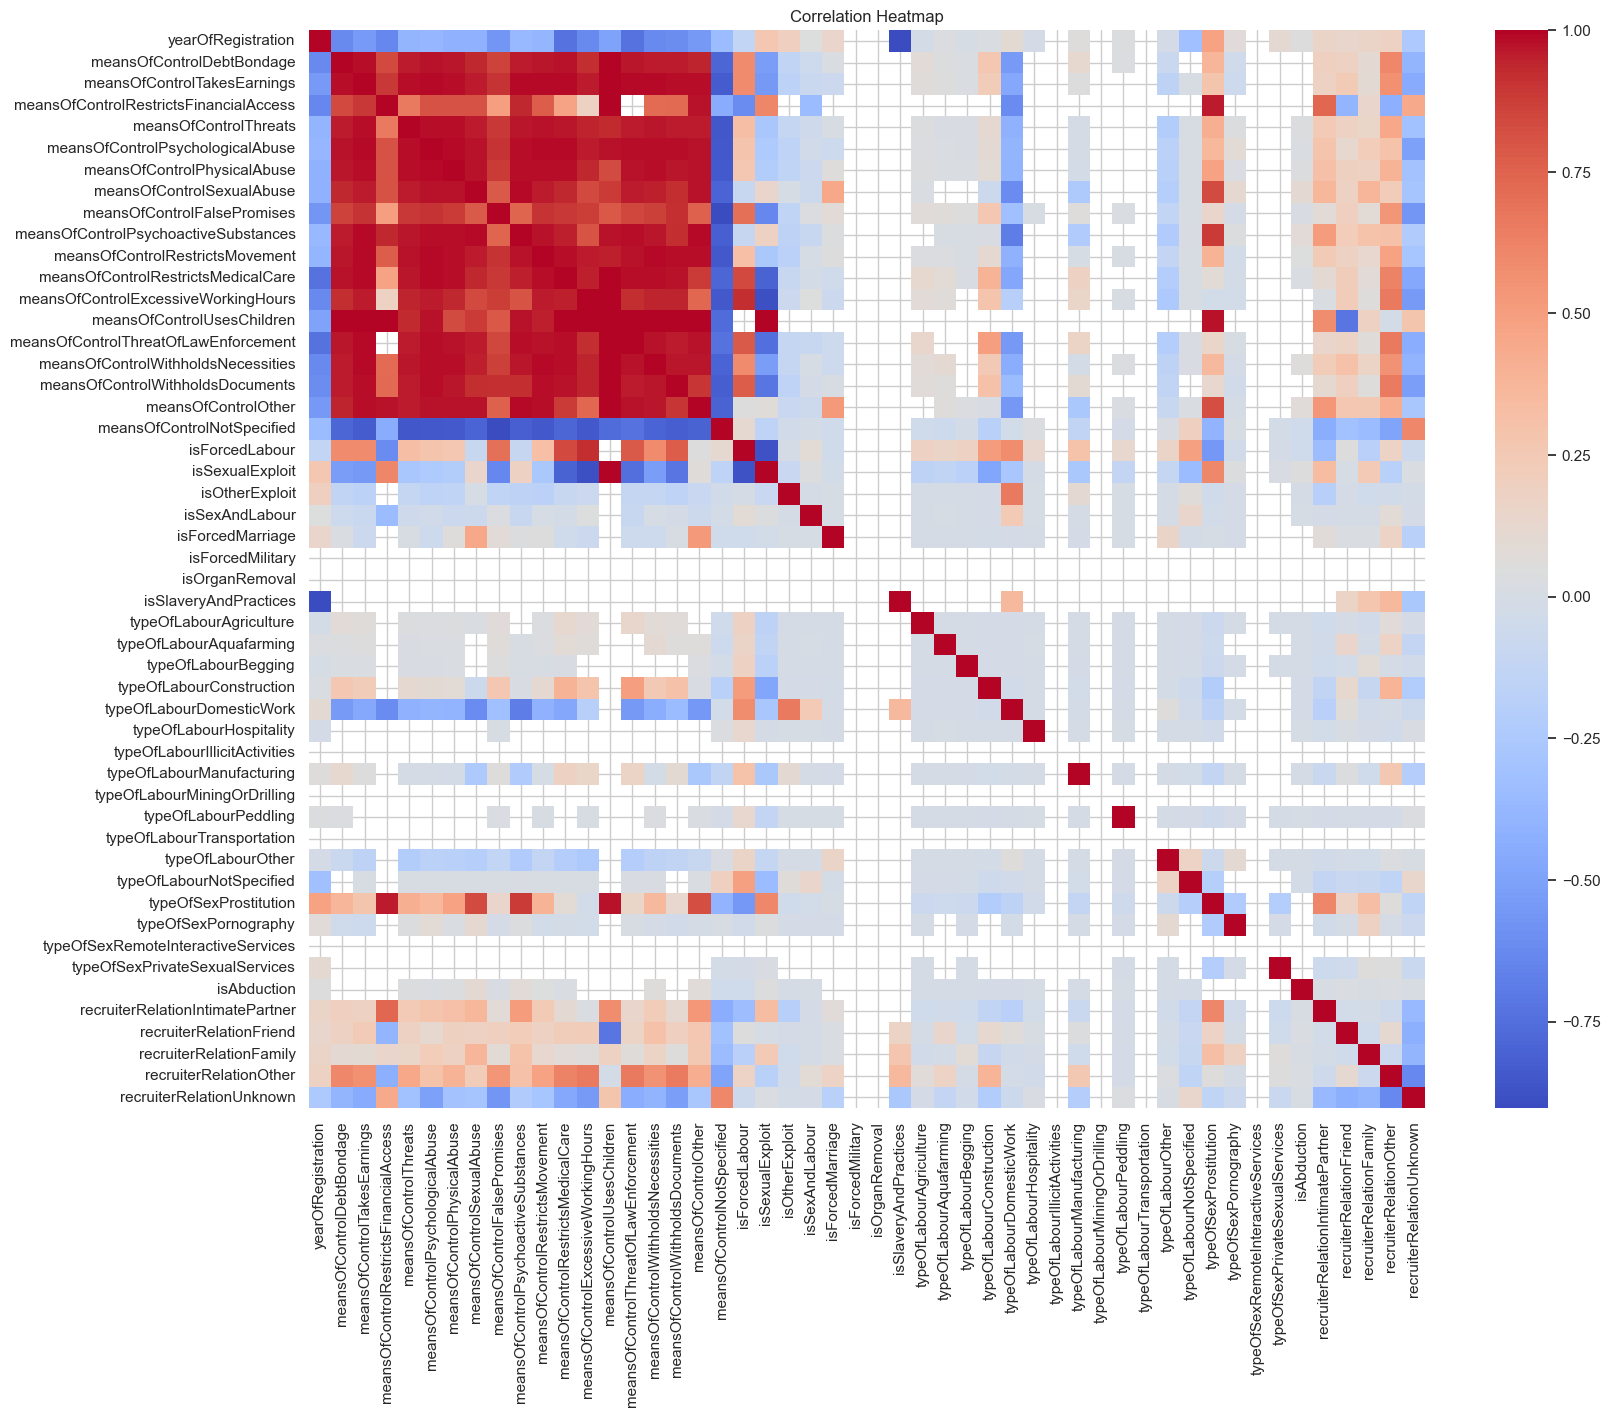

In [28]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


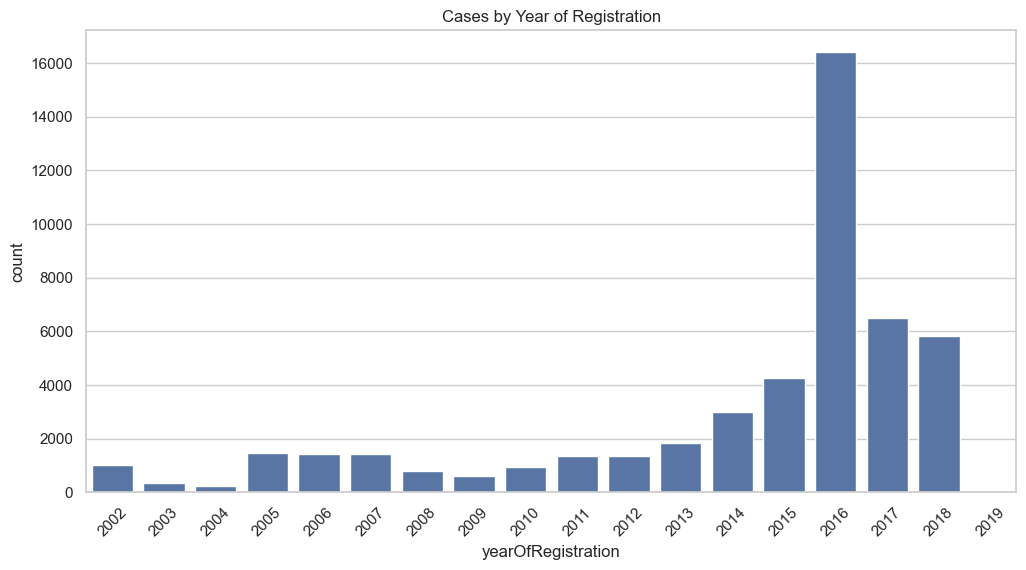

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(x='yearOfRegistration', data=df, order=sorted(df['yearOfRegistration'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Cases by Year of Registration")
plt.show()


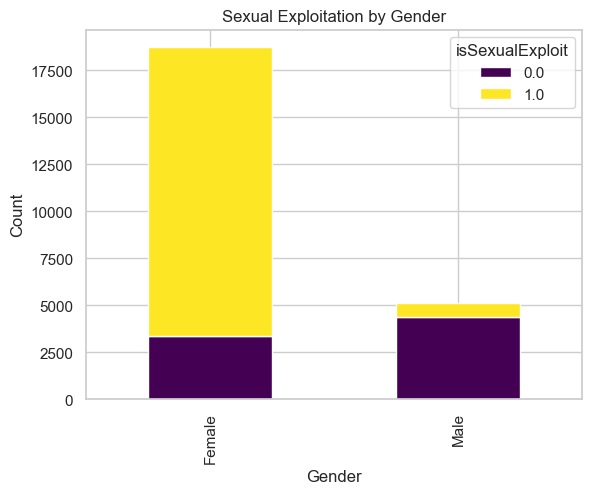

In [30]:
cross_tab = pd.crosstab(df['gender'], df['isSexualExploit'])
cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sexual Exploitation by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(title='isSexualExploit')
plt.show()


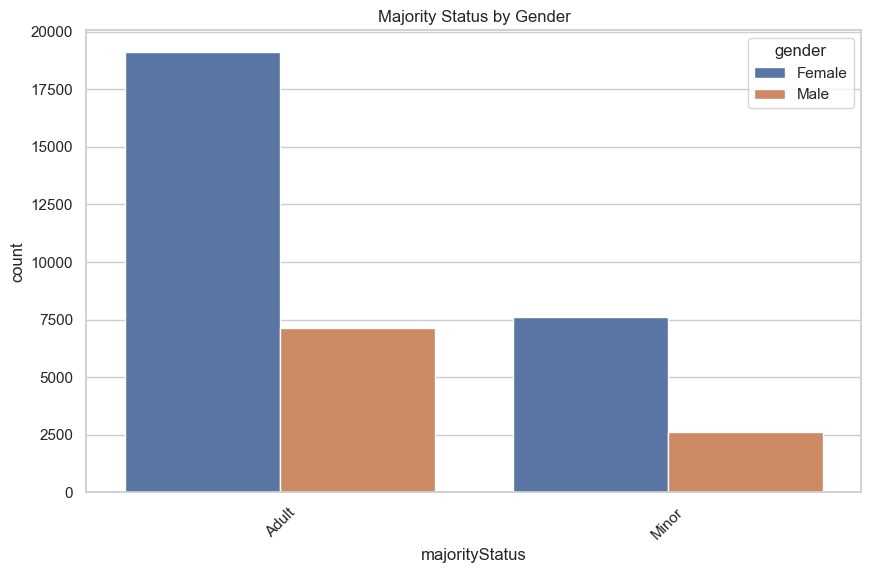

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='majorityStatus', hue='gender')
plt.title("Majority Status by Gender")
plt.xticks(rotation=45)
plt.show()


In [32]:
# Create a mapping from ISO alpha-2 codes to full country names
def code_to_country(code):
    try:
        if pd.isna(code) or code == '00':
            return 'Unknown'
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Apply the mapping
df['citizenship_country'] = df['citizenship'].apply(code_to_country)

# Count occurrences
country_counts = df['citizenship_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Cases by Citizenship Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [33]:
country_counts = df['CountryOfExploitation'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Exploitation Cases by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [34]:
subset = df[['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']].dropna().copy()
subset = subset[subset['typeOfExploitConcatenated'] != '']

subset = subset.groupby(['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']).size().reset_index(name='count')

# Create node list
all_nodes = pd.concat([
    subset['gender'],
    subset['typeOfExploitConcatenated'],
    subset['CountryOfExploitation']
]).unique().tolist()

# Map node labels to index
label_to_idx = {label: idx for idx, label in enumerate(all_nodes)}

# Create links
source = subset['gender'].map(label_to_idx)
target = subset['typeOfExploitConcatenated'].map(label_to_idx)
middle_target = subset['CountryOfExploitation'].map(label_to_idx)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=subset['count']
    )
)])

fig.update_layout(title_text="Sankey Diagram: Gender → Type of Exploitation", font_size=10)
fig.show()


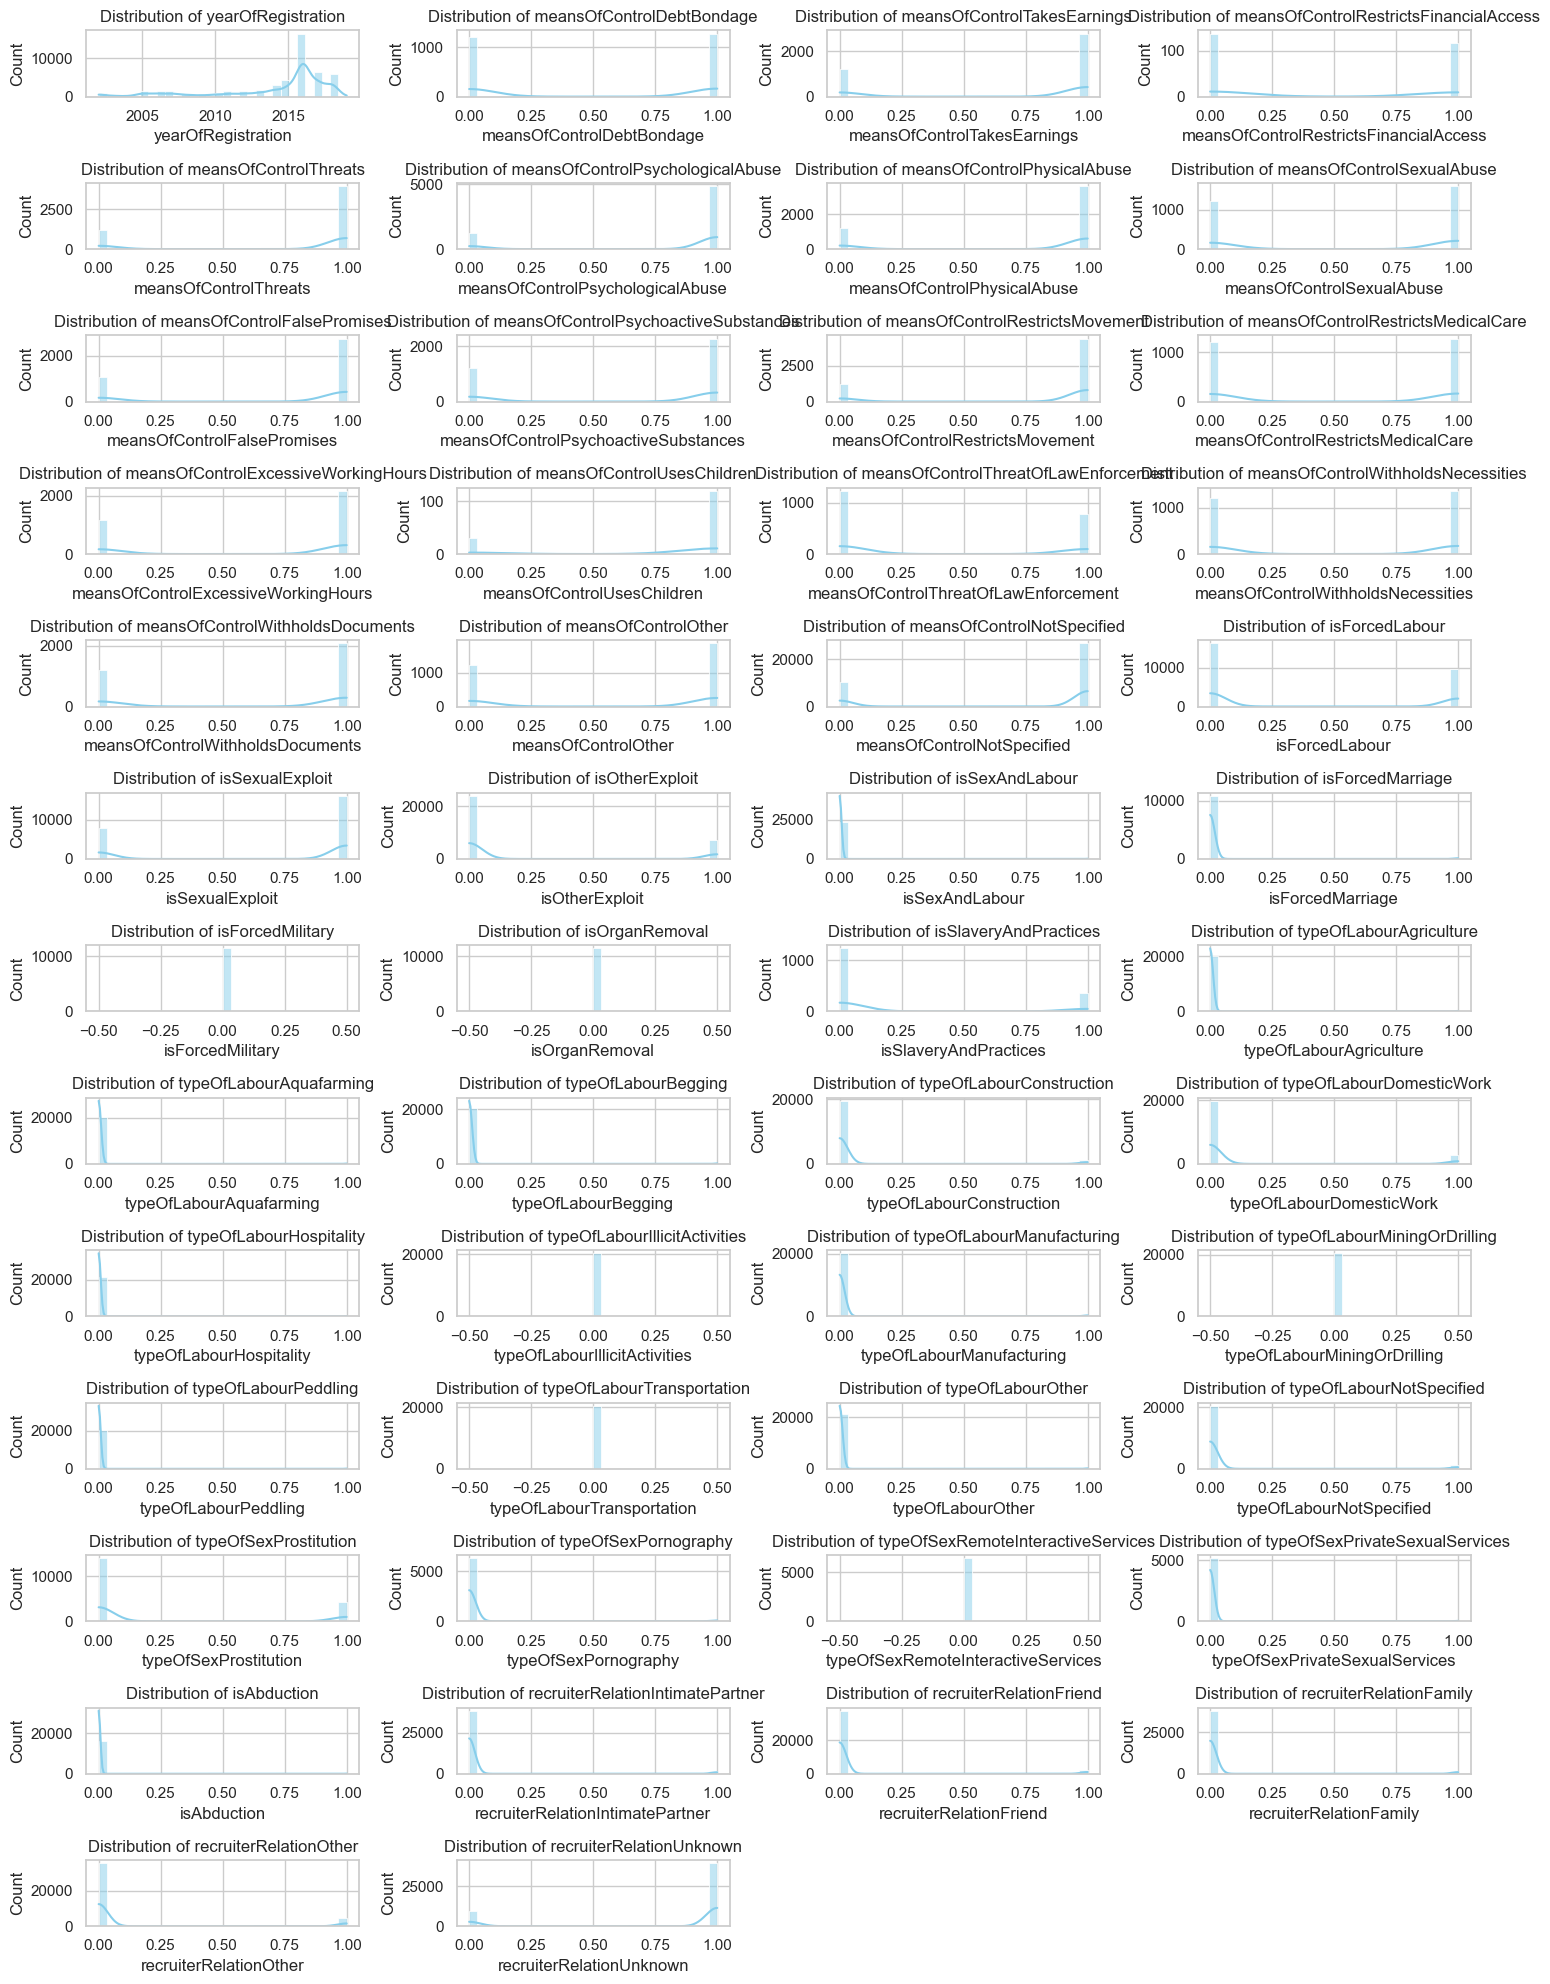

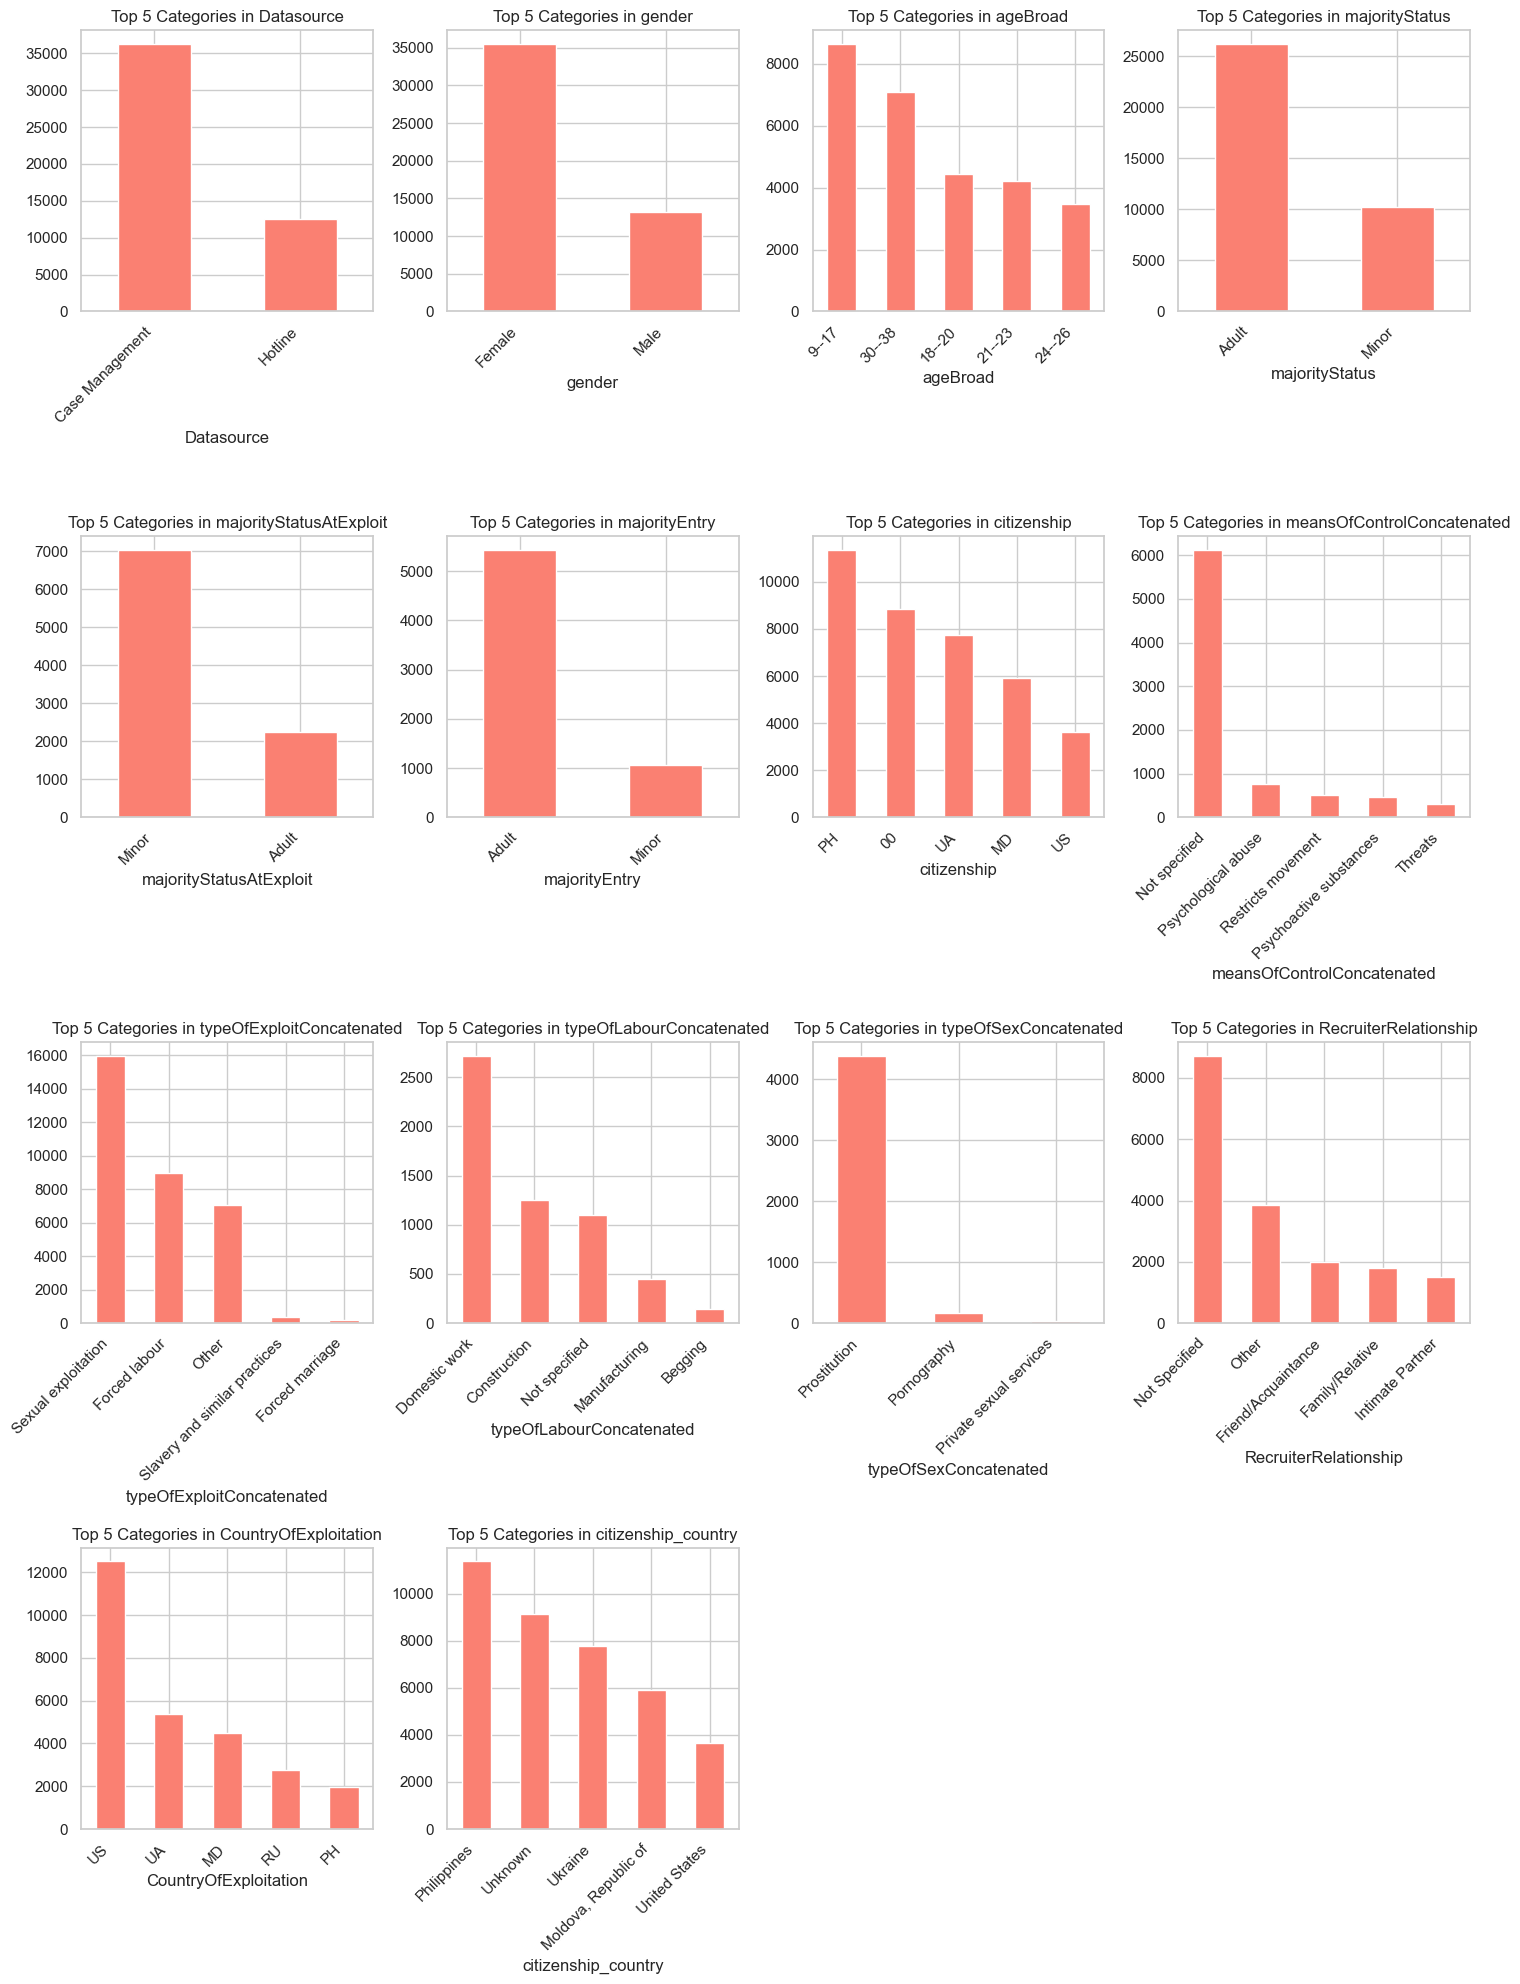

In [35]:
# Set up a grid of subplots to accommodate all features
num_columns = df.select_dtypes(include=['float64', 'int64']).columns
cat_columns = df.select_dtypes(include=['object']).columns

# Set up the plot for numerical features
plt.figure(figsize=(15, 20))

# Plot distributions for numeric features
for i, column in enumerate(num_columns):
    plt.subplot(len(num_columns) // 4 + 1, 4, i+1)
    sns.histplot(df[column].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f'Distribution of {column}')

# Apply tight layout after all numerical plots are created
plt.tight_layout()
plt.show()

# Set up the plot for categorical features
plt.figure(figsize=(15, 20))

# Plot distributions for categorical features
for i, column in enumerate(cat_columns):
    plt.subplot(len(cat_columns) // 4 + 1, 4, i+1)
    
    # Get top 5 values and their counts
    top_5 = df[column].value_counts().nlargest(5)
    
    # Create bar plot
    ax = top_5.plot(kind='bar', color="salmon")
    plt.title(f'Top 5 Categories in {column}')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust subplot to make room for labels
    plt.subplots_adjust(bottom=0.3)

# Apply tight layout after all categorical plots are created
plt.tight_layout()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.8)

plt.show()


bro this is crazy, i cannot understand anything lol

The numerical variables are actually binary categorical aside from a few. They only fluctuate between 0 and 1

In [36]:
# Clean up ageBroad formatting
df['ageBroad'] = df['ageBroad'].str.replace('--', '-', regex=False)

# Add victim count column
df['Victims'] = 1

# Filter out missing values
filtered_df = df[df['ageBroad'].notna()]

# Group and count
grouped = filtered_df.groupby(['gender', 'ageBroad'])['Victims'].sum().reset_index()

# Define proper order of age groups
age_order = ['0-8', '9-17', '18-20', '21-23', '24-26', '27-29', '30-38', '39-47', '48-56', '57+']
grouped['ageBroad'] = pd.Categorical(grouped['ageBroad'], categories=age_order, ordered=True)
grouped = grouped.sort_values(['ageBroad'])

# Plot
fig = px.bar(
    grouped,
    x='ageBroad',
    y='Victims',
    color='gender',
    barmode='group',
    title='Human Trafficking Victims by Age Group and Gender',
    labels={'Victims': 'Number of Victims', 'ageBroad': 'Age Group'}
)

fig.update_layout(width=800, height=500)
fig.show()


females are more likely to be human trafficked than males. the highest number of victims are in the age range of 30-38 where we can assume it's because of manual work labour, while females highest victims range between 9-17 which could be bc of sexual exploitation. proof of the assumption

## 1.1 Handling missing values

<Figure size 1000x600 with 0 Axes>

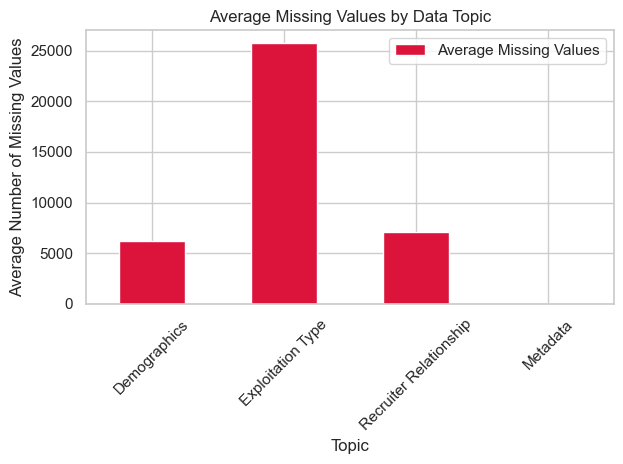

In [37]:
# Group columns by topic
demographic_cols = ['gender', 'ageBroad', 'majorityStatus', 'citizenship']
exploitation_cols = ['isForcedLabour', 'isSexualExploit', 'isOtherExploit', 'isForcedMilitary']
recruitment_cols = ['recruiterRelationIntimatePartner', 'recruiterRelationFriend', 'recruiterRelationFamily', 'recruiterRelationOther', 'recruiterRelationUnknown']
metadata_cols = ['yearOfRegistration', 'Datasource']

# Calculate missing values for each group
missing_by_topic = pd.DataFrame({
    'Demographics': df[demographic_cols].isnull().sum().mean(),
    'Exploitation Type': df[exploitation_cols].isnull().sum().mean(), 
    'Recruiter Relationship': df[recruitment_cols].isnull().sum().mean(),
    'Metadata': df[metadata_cols].isnull().sum().mean()
}, index=['Average Missing Values']).T

# Create bar plot
plt.figure(figsize=(10, 6))
missing_by_topic.plot(kind='bar', y='Average Missing Values', color='crimson')
plt.title('Average Missing Values by Data Topic')
plt.xlabel('Topic')
plt.ylabel('Average Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


shows the broad groups from which values are missing. We have many missing values in exploitation type which might be a problem actually.

<Figure size 1000x600 with 0 Axes>

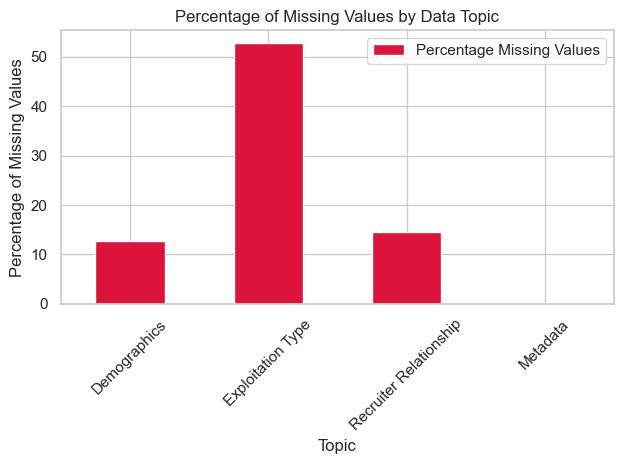

In [38]:
# Calculate missing values percentages for each group
missing_by_topic_pct = pd.DataFrame({
    'Demographics': (df[demographic_cols].isnull().sum().mean() / len(df)) * 100,
    'Exploitation Type': (df[exploitation_cols].isnull().sum().mean() / len(df)) * 100,
    'Recruiter Relationship': (df[recruitment_cols].isnull().sum().mean() / len(df)) * 100, 
    'Metadata': (df[metadata_cols].isnull().sum().mean() / len(df)) * 100
}, index=['Percentage Missing Values']).T

# Create bar plot
plt.figure(figsize=(10, 6))
missing_by_topic_pct.plot(kind='bar', y='Percentage Missing Values', color='crimson')
plt.title('Percentage of Missing Values by Data Topic')
plt.xlabel('Topic')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.2 Outlier detection


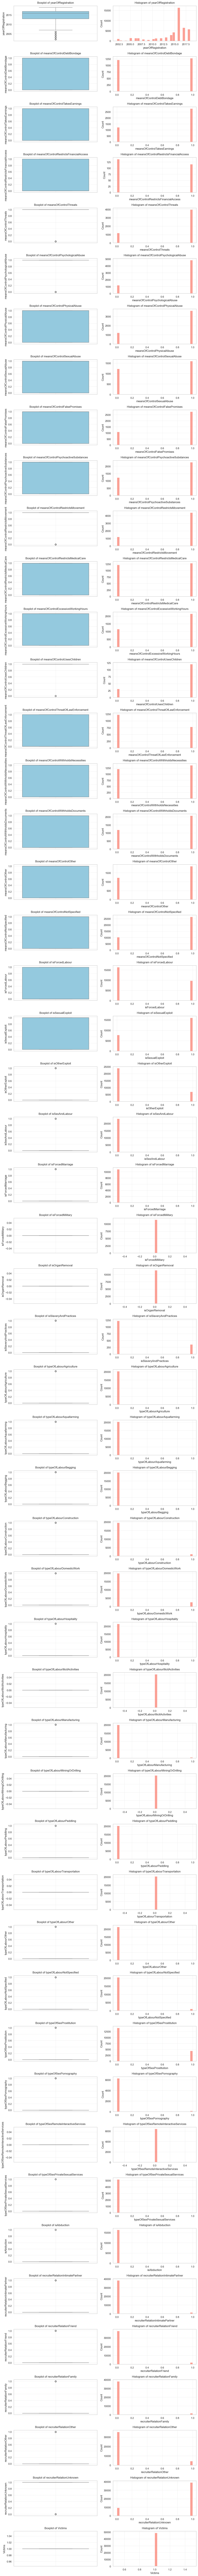


Outlier Statistics Summary:
                                Column  Outliers  Percentage  Lower Bound  Upper Bound
                    yearOfRegistration      4484    9.188336       2007.0       2023.0
             meansOfControlDebtBondage         0    0.000000         -1.5          2.5
           meansOfControlTakesEarnings         0    0.000000         -1.5          2.5
meansOfControlRestrictsFinancialAccess         0    0.000000         -1.5          2.5
                 meansOfControlThreats      1192    2.442573          1.0          1.0
      meansOfControlPsychologicalAbuse      1211    2.481507          1.0          1.0
           meansOfControlPhysicalAbuse         0    0.000000         -1.5          2.5
             meansOfControlSexualAbuse         0    0.000000         -1.5          2.5
           meansOfControlFalsePromises         0    0.000000         -1.5          2.5
  meansOfControlPsychoactiveSubstances         0    0.000000         -1.5          2.5
       meansOf

In [41]:
# Select numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create subplots with better spacing and sizing
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 3*len(numeric_cols)))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot boxplots and histograms for each numeric column
for i, col in enumerate(numeric_cols):
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Boxplot of {col}', pad=10)
    axes[i, 0].grid(True, alpha=0.3)
    
    # Histogram
    sns.histplot(data=df, x=col, ax=axes[i, 1], color='salmon', bins=30)
    axes[i, 1].set_title(f'Histogram of {col}', pad=10)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate IQR for each numeric column
outlier_stats = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_stats.append({
        'Column': col,
        'Outliers': len(outliers),
        'Percentage': (len(outliers)/len(df))*100,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

# Create a DataFrame for better visualization of outlier statistics
outlier_df = pd.DataFrame(outlier_stats)
print("\nOutlier Statistics Summary:")
print(outlier_df.to_string(index=False))


## TO-DO

guys, i think we should separate the eda in a more organised way cuz its kinda a mess and theres gonna be a lot of graphs. I would separate it in different parts to analyse its features and how they interact with other ones: 
- description of the victims (ageBroad	majorityStatus	majorityStatusAtExploit	majorityEntry	citizenship), 
- means of control 
- type of explotation 
- type of labour 
- type of sexual exploitation
- types of recuiter relationship and country of exploitation

possible interactions where we can take insights from:

### Victim Description Interactions

With Means of Control:
ageBroad × meansOfControl:
Younger victims may be more susceptible to certain controls (e.g., emotional abuse, threats, isolation), while adults may be more prone to financial coercion.

citizenship × meansOfControl:
Foreign nationals might experience passport confiscation more often than locals.

With Type of Exploitation:
majorityStatusAtExploit × typeOfExploitation:
Children may be more likely exploited for forced marriage or begging, while adults may be more likely in labor or sex work.

ageBroad × typeOfExploitation:
Useful to visualize which age ranges are associated with specific exploitation types.

With Recruiter Relationship:
majorityEntry × recruiterRelationX:
Are minors more likely to be recruited by family members or intimate partners?

### Means of Control Interactions
With Type of Exploitation:
meansOfControl × typeOfExploitation:
Do sexual exploitation victims experience more threats or isolation? Do labor exploitation cases often include debt bondage?

With Recruiter Relationship:
recruiterRelationX × meansOfControl:
Intimate partners may use emotional manipulation, while strangers use physical threats.

### Type of Labour Interactions
With Victim Description:
ageBroad × typeOfLabour:
Younger victims might be in domestic work or street work, older ones in construction or agriculture.

With Country of Exploitation:
country × typeOfLabour:
Some countries might have specific trends (e.g., construction in Gulf countries, agriculture in Southern Europe).

###  Type of Sexual Exploitation Interactions
With Gender and Age:
gender × ageBroad × typeOfSexualExploitation:
Female minors might show specific patterns of sexual exploitation not seen in other groups.

With Means of Control:
typeOfSexualExploitation × meansOfControl:
Certain sexual exploitations may rely heavily on drug dependency, coercion, or emotional threats.

###  Country of Exploitation & Recruiter Relationship Interactions
With Victim Profile:
country × recruiterRelationX × majorityStatus:
Family-based recruitment may be more prevalent in certain regions.

With Type of Exploitation:
country × recruiterRelationX × typeOfExploitation:
In some countries, sexual exploitation might occur mostly through intimate partners, in others through strangers or recruiters.


50% missing values?:((

# Step 2: Feature engineering

# Step 3: Model selection

# Step 4: Model validation

# Step 5: Conclusion